# Random Forest


Decision Trees are versatile (can do both regression and classificatiion) algorithms. 

Using **deep** Decision Trees we can fit complex dataset. However, it suffers from **high variance** (overfitting).

One technique to reduce the high variance of Decision Trees is to train a **group of Decision Trees**, each on a different random subset of the training set. 

To make predictions, we just obtain the predictions of all individual trees. Then, predict the class that gets the most votes. 

Such an ensemble of Decision Trees is called a **Random Forest**.

Despite its simplicity, this is one of the most powerful Machine Learning algorithms available today.


## Random Forest vs. SVM & Boosting

Support Vector Machines (SVMs) and boosting technique are very powerful for binary classification problems. However, these techniques do not extend naturally to **multi-class problems**.

In principle, classification trees and forests work with any number of classes (~20 to ~30).

In average, classification forests have shown good generalization, even in problems with **high dimensionality**. 


## Training Random Forests: Bagging

A random decision forest is generally trained via the **bagging** method (or sometimes pasting).

Bagging stands for **bootstrap aggregation**.

In bootstrapping we use the same training algorithm for every predictor, but to **train them on different random subsets** of the training set. 
- When sampling is performed with replacement, this method is called bagging. 
- When sampling is performed without replacement, it is called pasting.


<img src="https://cse.unl.edu/~hasan/Pics/Bagging.png" width=700 height=400>


## How Do Random Forests Reduce Variance to Improve Generalizability?

A key aspect of random forests is the fact that its component trees are all **randomly different from one another**. 

This leads to **de-correlation between the individual tree predictions** and, in turn, to improved generalization.

Forest randomness also helps achieve high robustness with respect to **noisy data**.


## Randomization Techniques for Training Random Forests

Randomness is injected into the trees during the training phase. 

Two of the most popular ways of doing so are:
     - Random training data set sampling  (e.g., bagging) 
     - Randomized node optimization (RNO)


Unlike bagging, RNO uses use all available training data and controls the randomness by varying the number of parameters for training.


## Tasks

In this notebook, we perform the following tasks.

1. **Explore the bagging method** for training Random Forests. 
2. Investigate whether dimensionality reduction technique (e.g., PCA) improves the performance of Decision Tree/Random Forest.
3. Use Random Forest for feature selection.
4. Study a variant of Random Forests that is known as extremely randomized trees or **Extra-Trees**.


## Dataset: MNIST


We will use the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.


There are 70,000 images. Each image is 28x28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

Thus, each image has 784 features. 

In [1]:
import time
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

## Load Data and Create Data Matrix (X) and the Label Vector (y)

In [2]:
# Load data using Scikit-Learn
mnist = fetch_openml('mnist_784', cache=False)

X = mnist["data"].astype('float64')
y = mnist["target"].astype('int64')

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


## Split Data Into Training and Test Subsets

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Task 1: Explore the Bagging Method for Growing (Training) Random Forests



To reduce the variance of a Decision Tree we grow a Random Forest.

The Random Forest algorithm introduces extra randomness when growing trees.

Instead of searching for the very best feature when splitting a node, it searches for the best feature among a **random subset of features**. This results in a greater tree diversity, which trades a higher bias for a lower variance, generally yielding an overall better model. 


A Random Forest is an **ensemble of Decision Trees**. It is generally trained via the bagging method (or sometimes pasting). 

Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, we can instead use the **RandomForestClassifier class**, which is more convenient and optimized for Decision Trees (similarly, there is a RandomForestRegressor class for regression tasks). 

## Random Forest: Key Hyperparameters


We will use the following hyperparameters of the RandomForestClassifier class. 

For a full list of the hyperparameters visit: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier


- n_estimators : The number of trees in the forest. Default=10


- criterion : The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific. Default=”gini”


- max_depth : The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. Default=None


- min_samples_split : The minimum number of samples required to split an internal node: Default=2

        -- If int, then consider min_samples_split as the minimum number.
        -- If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.
        
        
        
- min_samples_leaf : The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression. Default=1


         -- If int, then consider min_samples_leaf as the minimum number.
         -- If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.


- max_features : The number of features to consider when looking for the best split. Default="auto".

        -- If int, then consider max_features features at each split.
        -- If float, then max_features is a fraction and int(max_features * n_features) features are considered at each split.
        -- If “auto”, then max_features=sqrt(n_features).
        -- If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
        -- If “log2”, then max_features=log2(n_features).
        -- If None, then max_features=n_features.


- max_leaf_nodes : Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes. Default=None


- class_weight : Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y. Default=None

         -- The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))



- oob_score : Whether to use out-of-bag samples to estimate the generalization accuracy. Default=False

        -- When using a subset of the available samples the generalization accuracy can be estimated with the out-of-bag samples by setting oob_score=True. Then, we can get the score of the training dataset obtained using an out-of-bag estimate (use the $oob\_score\_$ attribute)
        
        
- bootstrap : Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree. Default=True
 

- verbose : Controls the verbosity when fitting and predicting. Default=0


In [4]:
%%time

t0 = time.time()
forest_clf = RandomForestClassifier(n_estimators=1000, criterion="gini", max_features="auto", 
                                    max_depth=32, class_weight="balanced", oob_score=True, verbose=1, n_jobs=-1)

forest_clf.fit(X_train, y_train)
t1 = time.time()

training_forest_clf = t1 - t0

print("Random Forest Training took {:.2f}s".format(training_forest_clf))

y_test_predicted = forest_clf.predict(X_test)
accuracy_forest_clf = accuracy_score(y_test, y_test_predicted)
print("\nTest Accuracy: ", accuracy_forest_clf)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

print("\nScore of the training dataset obtained using an out-of-bag estimate: ", forest_clf.oob_score_)
print("\n")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.8min finished


Random Forest Training took 142.62s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.0s



Test Accuracy:  0.9694285714285714

Test Confusion Matrix:
[[1369    0    1    0    2    2    6    0    7    0]
 [   0 1560    5    5    3    0    2    2    2    1]
 [   2    2 1406    7    4    1    5    8    7    1]
 [   1    1   21 1364    0   14    0   11   20    3]
 [   1    0    1    0 1315    0    6    4    2   21]
 [   1    2    3   10    2 1187   12    1    9    4]
 [   7    2    1    0    3    7 1362    0    5    0]
 [   3    6   18    0   10    0    0 1400    4   17]
 [   0    9    5    5    5    4    3    0 1318   19]
 [   4    1    4   21   11    4    2   15    8 1291]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1387
           1       0.99      0.99      0.99      1580
           2       0.96      0.97      0.97      1443
           3       0.97      0.95      0.96      1435
           4       0.97      0.97      0.97      1350
           5       0.97      0.96      0.97      1231
      

[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.2s finished


## Task 2: Investigate Whether Dimensionality Reduction Technique (e.g., PCA) Improves the Performance of Decision Tree/Random Forest

We know that it is useful to **find disciminative features** for growing a Decision Tree. For this we have performing feature selection.

Now we would like to see whether we can extract features to grow a Decision Tree.

We use dimensionality reduction to extract features.

We apply the Principle Component Analysis (PCA) dimensionality reduction technique to project the MNIST dataset (784 features) to a lower dimensional space by retaining maximum variance (95%).

The PCA **extracts 154 features** which we use to train a Random Forest classifier.

Our goal is to see whether the extracted features improve the performance of the Random Forest.

In [5]:
pca = PCA(n_components=0.95)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("Number of Principle Components (Extracted Features): ", pca.n_components_)  

Number of Principle Components (Extracted Features):  154


In [6]:
%%time

forest_clf_pca = RandomForestClassifier(n_estimators=1000, criterion="gini", max_features="auto", 
                                    max_depth=32, class_weight="balanced", oob_score=True, verbose=1, n_jobs=-1)

forest_clf_pca.fit(X_train_pca, y_train)

y_test_predicted = forest_clf_pca.predict(X_test_pca)
print("Test Accuracy (PCA): ", accuracy_score(y_test, y_test_predicted))

print("\nTest Confusion Matrix (PCA):")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report (PCA):")
print(classification_report(y_test, y_test_predicted))

print("\nScore of the training dataset obtained using an out-of-bag estimate (PCA): ", forest_clf.oob_score_)
print("\n")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.8s


Test Accuracy (PCA):  0.9497142857142857

Test Confusion Matrix (PCA):
[[1358    0    4    2    4    3   10    2    4    0]
 [   0 1553   10    5    2    0    4    2    4    0]
 [   6    3 1361   14   13    2    4    7   30    3]
 [   4    0   21 1326    1   23    4   17   30    9]
 [   1    1    6    1 1298    0    8    2    6   27]
 [   4    2    6   26    9 1157   12    3    4    8]
 [   9    1    5    1    7   14 1348    0    2    0]
 [   2    5   21    1   15    1    0 1384   10   19]
 [   1   10   12   31    8   23    4    1 1261   17]
 [   7    1    5   23   35    8    2   24    6 1250]]

Classification Report (PCA):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1387
           1       0.99      0.98      0.98      1580
           2       0.94      0.94      0.94      1443
           3       0.93      0.92      0.93      1435
           4       0.93      0.96      0.95      1350
           5       0.94      0.94      0.94

[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.0s finished


## Observation: Dimensionality Reduction with Random Forest

We observe that PCA **lowers the performance** of a Random Forest classifier. This is due to the fact that extracted features (original features projected into a lower dimension) don't meaningfully combine to produce effective desion rules.

Machine Learning algorithms that create decision rules by composing knowledge (e.g., decision tree uses a combination of the features to contruct a decision rule) don't benefit from dimensionality reduction. 

Thus, **we shouldn't use PCA with Decision Tree or Random Forest**.

## Task 3: Use Random Forest for Feature Selection

Random Forest can be used for feature selection by using **feature importance**.

**Feature Selection** is a very useful Machine Learning technique that we often use. Random Forests are very handy to get a quick understanding of what features actually matter. This helps to perform feature selection.

Random Forests enable us to perform feature selection by finding the **relative importance of each feature**. 

A Random Forest measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). 

More precisely, it is a **weighted average**, where each node’s weight is equal to the number of training samples that are associated with it.

Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. 

We can access the result using the $feature\_importances\_$ variable. 

Following example shows the plot of each pixel's importance in the MNIST dataset after trained by a Random Forest Classifier.

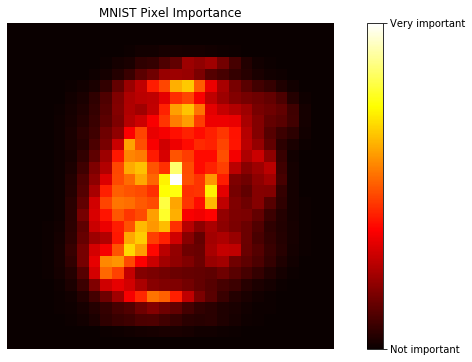

In [7]:
# Pixel importances on 28*28 image
importances = forest_clf.feature_importances_
image = importances.reshape(28, 28)

# Plot pixel importances
plt.figure(figsize=(12, 6))
plt.title("MNIST Pixel Importance")

plt.imshow(image, cmap=mpl.cm.hot,interpolation="nearest")
cbar = plt.colorbar(ticks=[forest_clf.feature_importances_.min(), forest_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.axis("off")

plt.show()

## Task 4: Study a Variant of Random Forest - Extremely Randomized Trees or Extra-Trees

Random Forests are used to reduce the variance of Decision Trees. 

Interestingly, we can **reduce the variance** of the Random Forests by growing **extremely randomized trees**. In Scikit-Learn it is implemented by the ExtraTreesClassifier and ExtraTreesRegressor classes.

These Extra-Trees take randomness one step further by using **random thresholds** for each feature rather than searching for the best possible thresholds (like regular Decision Trees do).

Thus, Extra-Trees trade **more bias for a lower variance**.

Extra-Trees are much faster to train than regular Random Forests since finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

Scikit-Learn’s ExtraTreesClassifier API is identical to the RandomForestClassifier class. Similarly, the Extra TreesRegressor class has the same API as the RandomForestRegressor class.

### Note:
By deault the ExtraTreesClassifier "bootstrap" hyperparameter is set to False. As a consequence, the whole dataset is used to build each tree. To using the bagging method, we need to explicity set it to True.


### RandomForestClassifier vs. ExtraTreesClassifier

It is hard to tell in advance whether a RandomForestClassifier will perform better or worse than an ExtraTreesClassifier. 

Generally, the only way to know is to try both and compare them using cross-validation (and tuning the hyperparameters using grid search).

In [8]:
%%time

t0 = time.time()
extra_trees_clf = ExtraTreesClassifier(n_estimators=1000, criterion="gini", max_features="auto", 
                                       max_depth=32, class_weight="balanced", oob_score=True, 
                                       bootstrap=True, verbose=1, n_jobs=-1)
extra_trees_clf.fit(X_train, y_train)
t1 = time.time()

training_extra_tree = t1 - t0

print("Extra Tree Training took {:.2f}s".format(training_extra_tree))


y_test_predicted = extra_trees_clf.predict(X_test)
accuracy_extra_trees = accuracy_score(y_test, y_test_predicted)
print("\nTest Accuracy: ", accuracy_extra_trees)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

print("\nScore of the training dataset obtained using an out-of-bag estimate: ", extra_trees_clf.oob_score_)
print("\n")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.1min finished


Extra Tree Training took 103.34s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.0s



Test Accuracy:  0.9674285714285714

Test Confusion Matrix:
[[1367    0    1    0    2    3    7    0    7    0]
 [   0 1562    6    4    3    0    1    1    2    1]
 [   3    3 1399    7    3    1    5    9   12    1]
 [   2    1   19 1359    0   17    2   11   18    6]
 [   2    0    0    0 1313    0    5    4    1   25]
 [   1    2    4   10    2 1187   10    1    9    5]
 [   9    2    1    0    4    7 1361    0    3    0]
 [   4    7   21    0    6    0    0 1390    4   26]
 [   0    9    5    8    5    6    2    0 1314   19]
 [   4    2    4   19   11    6    2   14    7 1292]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1387
           1       0.98      0.99      0.99      1580
           2       0.96      0.97      0.96      1443
           3       0.97      0.95      0.96      1435
           4       0.97      0.97      0.97      1350
           5       0.97      0.96      0.97      1231
      

[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.2s finished


# Summary of Results 

In [9]:
data = [["Random Forest (1000 trees)", accuracy_forest_clf, training_forest_clf], 
        ["Extra-Trees (1000 trees)", accuracy_extra_trees, training_extra_tree]]

pd.DataFrame(data, columns=["Classifier", "Accuracy", "Running-Time"])

,Classifier,Accuracy,Running-Time
0,Random Forest (1000 trees),0.969429,142.620684
1,Extra-Trees (1000 trees),0.967429,103.340217


## Comparative Understanding

Based on the performance results we see that Extra-Trees and Random Forests are comparable. 

- Extra-Trees are **faster at the cost of slightly higher bias** (i.e., slightly smaller test accuracy). The speed in training comes from using random threshold then searching for an optimal threshold.
- The performance difference is insignificant.

To get a better comparative understanding we should tune the hyperparameters for these two models.